<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Sebastian Tinoco
- Auxiliar: Catherine Benavides, Consuelo Rojas
- Ayudante: Eduardo Moya, Nicolás Ojeda

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Benjamín Aguilar
- Nombre de alumno 2: Sebastián Vásquez


### **Link de repositorio de GitHub:** `https://github.com/sbstnvsqz0/MDS7202`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

Tareas:
1. En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.). Comente sus decisiones y los resultados obtenidos con el modelo.

2. Luego, le pide responder las siguientes preguntas:
  *  ¿Es acaso un buen predictor de diabetes?,
  * ¿Qué buscan explicar las métricas utilizadas?
  * ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?

In [2]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


### 1.

Se reconocen variables categóricas y numéricas:
- Categóricas: Sex, HighCol, CholCheck, Smoker, HeatDiseaseorAttack, PhysActivity,Fruits, Veggies, HvyAlcoholConsump, DiffWalk, Stroke, HighBP, Diabetes, GenHlth (todas binarias excepto GenHlth)
- Numéricas: Age, BMI, MentHlth, PhysHlth

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
SEED = 42

X_train,X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!="Diabetes"],df["Diabetes"],test_size = 0.15, random_state=SEED,stratify=df["Diabetes"])

col_transformer = ColumnTransformer([("min_max_scaler",MinMaxScaler(),["Age","BMI"]),
                                     ("encoder",OneHotEncoder(drop="first"),["GenHlth"]),
                                     ("pass","passthrough",["DiffWalk","Stroke","HighBP","Veggies","Fruits","PhysActivity","HeartDiseaseorAttack","Smoker","Sex","HighChol","CholCheck"])], remainder="drop")


full_pipe = Pipeline([("col_transformer",col_transformer),
                      ("classifier",XGBClassifier(random_state=SEED))])

In [38]:
#import optuna
#from optuna.samplers import TPESampler
#def objective_function(trial):
#    X_train,X_aux,y_train,y_aux= train_test_split(df.loc[:,df.columns!="Diabetes"],df["Diabetes"],test_size = 0.3, random_state=SEED,stratify=df["Diabetes"])
#    X_val,X_test,y_val,y_test = train_test_split(X_aux,y_aux,test_size=0.33,random_state=SEED,stratify=y_aux)
#    params_xgb = {

#        "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
#        "n_estimators": trial.suggest_int("n_estimators",2,50),
#        "max_depth": trial.suggest_int("max_depth",3,10),
#        "max_leaves": trial.suggest_int("max_leaves",0,100),
#        "reg_alpha": trial.suggest_float("reg_alpha",0,1),
#        "reg_lambda": trial.suggest_float("reg_lambda",0,1)
#    }
#    pipeline_to_optimize = Pipeline([("col_transformer",col_transformer),
#                      ("classifier",XGBClassifier(random_state=SEED,**params_xgb))])
#    pipeline_to_optimize.fit(X_train,y_train)
#    yhat = pipeline_to_optimize.predict(X_val)
#    return f1_score(y_val,yhat)
#study = optuna.create_study(direction="minimize",sampler=TPESampler())
#study.optimize(objective_function,timeout=300)

[I 2024-06-09 06:58:57,994] A new study created in memory with name: no-name-cf803e74-f67d-4c14-a7e1-c88d83bc799b
C:\Users\sebas\AppData\Local\Temp\ipykernel_10744\1212570533.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-09 06:58:58,261] Trial 0 finished with value: 0.7252101961831042 and parameters: {'learning_rate': 0.008985767569069977, 'n_estimators': 40, 'max_depth': 3, 'max_leaves': 62, 'reg_alpha': 0.006376997028621489, 'reg_lambda': 0.3833817097065735}. Best is trial 0 with value: 0.7252101961831042.
C:\Users\sebas\AppData\Local\Temp\ipykernel_10744\1212570533.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

In [ ]:
#("min_max_scaler",MinMaxScaler(),["Age","BMI","MentHlth","PhysHlth"])
#("encoder",OneHotEncoder(drop="first"),["GenHlth"])

In [4]:
model = full_pipe.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(f"accuracy:{accuracy_score(y_test,y_pred)}\n" +
      f"recall:{recall_score(y_test,y_pred)}\n"+
      f"precision:{precision_score(y_test,y_pred)}\n"+
      f"f1 score:{f1_score(y_test,y_pred)}")

accuracy:0.745850622406639
recall:0.7898906073179932
precision:0.7259490379615184
f1 score:0.7565712221118237


Con respecto a las decisiones tomadas, se escalaron las variables numéricas con un min_max para dejar todas las features en un mismo rango, se usó un encoder para GenHlth para considerarla categórica, teniendo en cuenta que 5 es que el paciente se siente con muy buena salud y 1 con muy mala. Las demás variables se dejaron como estaban a excepción de MenHlth y PhysHlth, pues se entienden como variables muy personales del paciente y dificiles de interpretar, pues son valores que van de 1 a 30, con lo cual seguramente se trate de la salud en el último mes o algo del estilo, evaluando cada día del mes, la cual realmente es complicada a la hora de tenerla en cuenta.

### 2.-
El predictor no es tan bueno como se esperaba, pues en general se quieren tener pocos falsos positivos y pocos falsos negativos. En ese sentido es bueno utilizar el f1-score y el accuracy (el dataset está balanceado) y se tienen valores menores a 0.8. Las métricas utilizadas para la evaluación solo dan información de lo buena/mala clasificación que hace el modelo, sin embargo, no aseguran una buena elección de features del modelo.

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Tareas:
1. Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`.
2. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados.
3. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

### 1

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

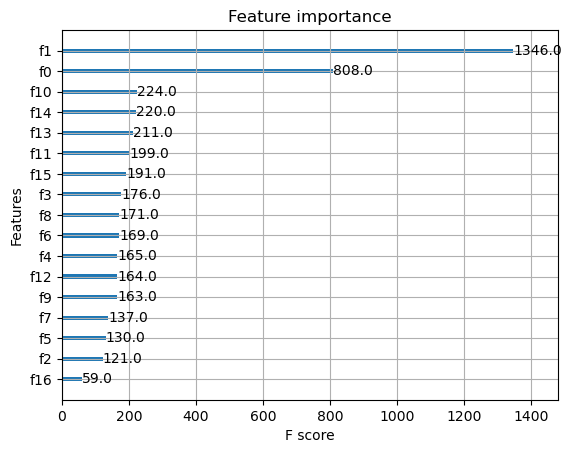

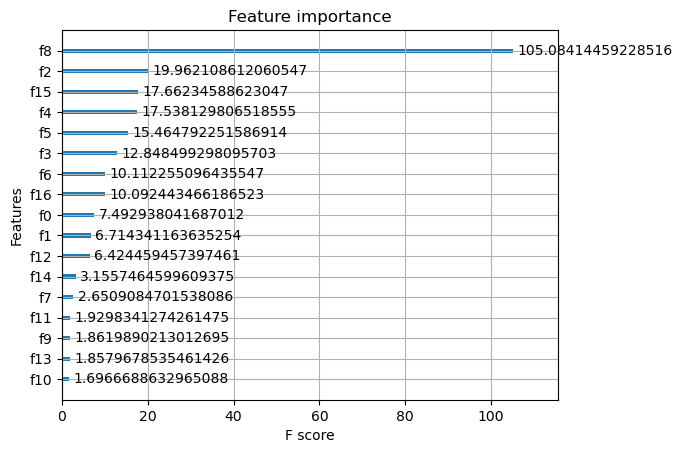

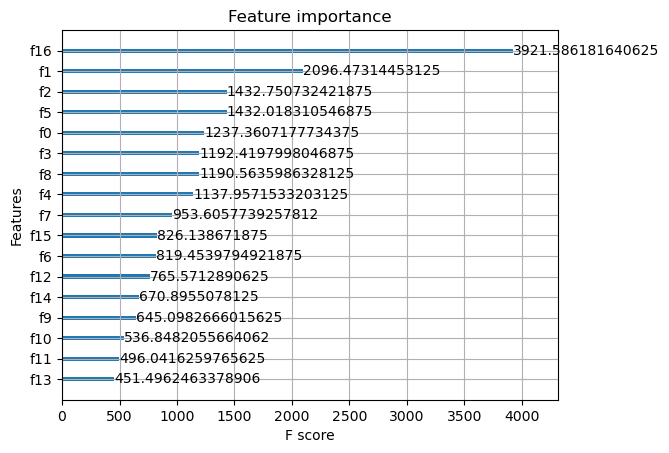

In [5]:
# Inserte su código aquí
from xgboost import plot_importance
plot_importance(model["classifier"],importance_type="weight")
plot_importance(model["classifier"],importance_type="gain")
plot_importance(model["classifier"],importance_type="cover")

In [6]:
model["col_transformer"].get_feature_names_out()[10]

'pass__Fruits'

In [7]:
df.corr()["Diabetes"]

Age                     0.278738
Sex                     0.044413
HighChol                0.289213
CholCheck               0.115382
BMI                     0.293373
Smoker                  0.085999
HeartDiseaseorAttack    0.211523
PhysActivity           -0.158666
Fruits                 -0.054077
Veggies                -0.079293
HvyAlcoholConsump      -0.094853
GenHlth                 0.407612
MentHlth                0.087029
PhysHlth                0.213081
DiffWalk                0.272646
Stroke                  0.125427
HighBP                  0.381516
Diabetes                1.000000
Name: Diabetes, dtype: float64

### 2
Los resultados claramente son distintos dependiendo del método. El primer gráfico de importancias dado weights hace sentido, pues las dos primeras features son variables numéricas con varios valores distintos, las cuales permiten filtrar los samples de varias maneras más en el árbol con respecto a las demás variables categóricas utilizadas. El segundo gráfico muestra la ganancia promedio que tienen los splits al utilizar una feature. En este caso la más importante es el HighBP, referida a si el paciente tiene la presión de sangre alta o no, lo cual tiene sentido, pues debe ser la variable binaria que más coincide con el valor de Diabetes. Finalmente el último gráfico muestra que el CholCheck, seguida del BMI son las variables que en promedio más número de samples divididos tienen, es decir seguramente se presenten muy temprano en los árboles.

### 3
Aún con los gráficos obtenidos es complicado comprender como trabaja el árbol en las partes intermedias a la hora de tomar decisiones. No se pueden determinar relaciones entre features que trabajan en conjunto para poder determinar si el paciente tiene diabetes o no. También tiene la desventaja de no tener idea sobre cuan errado se vuelve el modelo al cambiar el valor sobre la feature, lo cual podría ser relevante para obtener una importancia general de las features.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Tareas:
1. Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features.
2. Visualice los resultados de este método en un gráfico.
3. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?).
4. Además, responda las siguientes preguntas:
  - ¿Cómo mide la importancia de las features su propuesta?
  - ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿tienen sentido?
  - ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
  - Nombre y explique 3 ventajas y 3 desventajas del método implementado.

### 1

In [20]:
# Inserte su código aquí
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
results = permutation_importance(model, X_train, y_train, n_repeats=30, random_state=42)
feature_names = df.columns

### 2

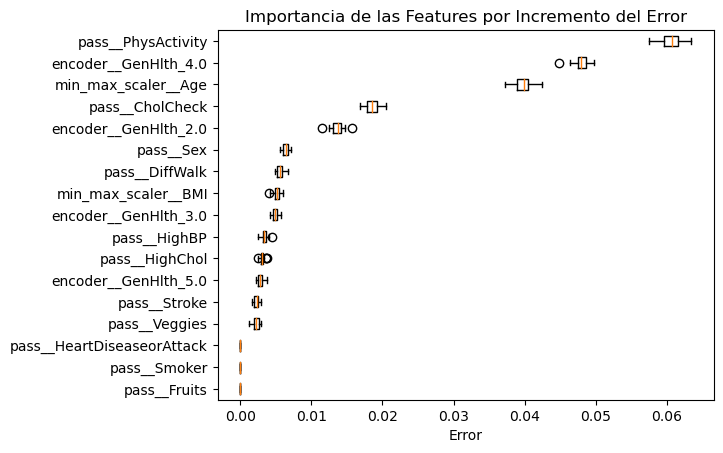

In [21]:
perm_sorted_idx = results.importances_mean.argsort()
plt.boxplot(
    results.importances[perm_sorted_idx].T,
    vert=False,
    labels=model["col_transformer"].get_feature_names_out()[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

### 3

En este caso se señalan las desviaciones del error al permutar una característica. Esto da noción de cuan volatil es la importancia de la característica, en el sentido de como puede cambiar el error dependiendo de la permutación utilizada. Por ejemplo para las variables fruits, smokoer y heatdiseaseorattack, el error no cambia dando a entender que los resultados son confiables aún cambiando estos valores, sin embargo los demás valores al ser permutados pueden aumentar o disminuir el error.

In [14]:
dict(zip(model["col_transformer"].get_feature_names_out(),results["importances_std"]))

{'min_max_scaler__Age': 0.0012158552463926494,
 'min_max_scaler__BMI': 0.0004969153321339512,
 'encoder__GenHlth_2.0': 0.0008012764775955899,
 'encoder__GenHlth_3.0': 0.00037841370427807837,
 'encoder__GenHlth_4.0': 0.0010671083671922133,
 'encoder__GenHlth_5.0': 0.00038203518743269173,
 'pass__DiffWalk': 0.0004554211673849003,
 'pass__Stroke': 0.0003638451654884673,
 'pass__HighBP': 0.00042786429399479045,
 'pass__Veggies': 0.00043570414683632855,
 'pass__Fruits': 0.0,
 'pass__PhysActivity': 0.0014532900454446835,
 'pass__HeartDiseaseorAttack': 0.0,
 'pass__Smoker': 0.0,
 'pass__Sex': 0.0003812191252852174,
 'pass__HighChol': 0.000289517896791146,
 'pass__CholCheck': 0.000960078805164995}

### 4

1.- En este caso se mide la importancia dado el aumento o disminución de error que se tiene en las predicciones, al permutan las características dentro de su dominio, esto considerando el modelo inicial como modelo de referencia para las predicciones.

2- Las 5 más significativas son el hacer actividad física (tiene sentido, pues la actividad física se usa como medida preventiva para la diabetes), el tener una salud de 4 (el no tener o tener una buena salud implicaría ser más probable o menos probable de tener diabetes), la edad (en general la a mayor edad se encuentran mayores casos de diabetes, con lo cual cambiar una edad alta por una pequeña podría inducir a un error), el tener una salud de 2 (lo mismo referido a tener salud de 4) y el BMI (tener índice de masa corporal alto incrementa el riesgo de tener diabetes en la teoría). En general tienen sentido y al equivocarse estas son las que más bajan el rendimiento del modelo.


3.- Ahora si se tiene una métrica definida para poder ver cuan importante es tener la información de correcta de cierta variable o no. En ese sentido cambian las features más relevantes, teniendo estas más sentido, pues están referidas también al rendimiento del modelo.

4.- 

Con respecto a las ventajas:
- Se tiene que este modelo arroja valores fáciles de interpretar a la hora de ver la importancia de las features.
- Da interacción entre características, pues permuta de forma global las features.
- No requiere volver a entrenar el modelo, lo cual da ventajas en tiempo con respecto a otros métodos.

Con respecto a las desventajas:
- Necesita las labels para poder dar una métrica.
- Features correlacionadas al ser permutadas pueden dar conjuntos de datos poco realistas.
- Está asociada principalmente a error del modelo, lo cual si bien sirve, a veces gustaría ver como influye en el recall o en la presicion para ciertos casos.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Tareas:
1. Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo.
2. ¿Qué representa cada número en su resultado?
3. ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [15]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 13.3 MB/s eta 0:00:000:00:01


In [16]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [27]:
# Inserte código para calcular shapley values aquí

import shap

explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(df.loc[:,df.columns!="Diabetes"])

# Borré los output desde acá porque no se me permitía subir el lab. 

PermutationExplainer explainer:  51%|██████████████████████████████▍                             | 35884/70692 [30:13<29:27, 19.70it/s]


KeyboardInterrupt: 

### 5.2 Aporte local (0.4 puntos)


1. Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:

  - ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?

  - ¿Existe algún patrón común entre las instancias analizadas?

  - ¿Es posible generalizar estas conclusiones a todo el dataset?

In [29]:
# Inserte código para generar gráficos de aporte local aquí

idx=1
shap.plots.waterfall(shap_values[idx,:],
                     max_display=14)

In [ ]:
idx=9
shap.plots.waterfall(shap_values[idx,:],
                     max_display=14)

In [ ]:
idx=150
shap.plots.waterfall(shap_values[idx,:],
                     max_display=14)

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

In [ ]:
# Inserte código para generar gráficos de aporte global aquí

shap.summary_plot(shap_values, df.loc[:,df.columns!="Diabetes"], plot_type="bar")

### 5.4 Scatter plot (0.4 puntos)


Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [ ]:
# Inserte código para generar gráficos de feature vs shap value aquí

shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

proba_predicted = model.predict_proba(df.loc[:,df.columns!="Diabetes"])[:, -1]

for name in feature_importance_names[:5]:
    shap.plots.scatter(shap_values[:,name],
                   color=proba_predicted)

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo Partial Dependence Plot para las mismas 5 variables con mayor impacto global usando una submuestra de 1000 observaciones. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

In [ ]:
# Inserte código para generar gráficos PDP aquí

X_sample = shap.utils.sample(df.loc[:,df.columns!="Diabetes"], 1000)

for name in feature_importance_names[:5]:
    sample_ind = 20
    shap.partial_dependence_plot(
        name,  model.predict, X_sample, model_expected_value=True,
        feature_expected_value=True, ice=True,
        shap_values=shap_values[sample_ind:sample_ind+1,:]
    )

## 6. Sistema de Reglas! (1.0 punto)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from alibi.explainers import AnchorTabular

2023-06-16 03:21:35.062920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 03:21:35.266905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-16 03:21:35.266966: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-16 03:21:35.308521: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-16 03:21:38.061257: W tensorflow/stream_executor/platform/de

In [ ]:
# Inserte su código para generar sistema de reglas aquí
predict_fn = lambda x: model.predict(x)
explainer = AnchorTabular(predict_fn, model.feature_names_in_, seed=1)
explainer.fit(X_train.to_numpy())

idx = 1000
# explicar predicción idx 1000
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

idx = 3001
# explicar predicción idx 3001
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

idx = 5751
# explicar predicción idx 5751
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>